Train Shape: (1300, 2) Test Shape: (130, 2)
opt x: //home/jovyan/at073-group50/dataset/20bn_jester_opt_x/train/Doing other things/102282/00001.jpg 
opt y: //home/jovyan/at073-group50/dataset/20bn_jester_opt_y/train/Doing other things/102282/00001.jpg
img x shape: (100, 176)


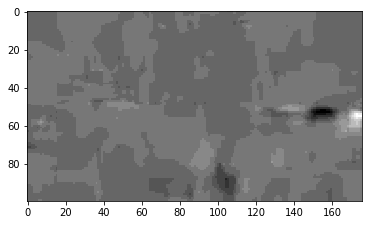

img y shape: (100, 176)


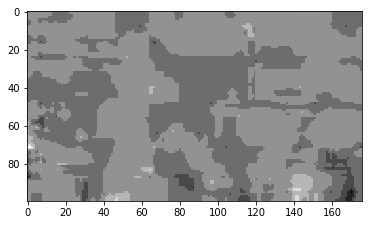

img stack shape: (100, 176, 2) 

opt x: //home/jovyan/at073-group50/dataset/20bn_jester_opt_x/train/Doing other things/102282/00002.jpg 
opt y: //home/jovyan/at073-group50/dataset/20bn_jester_opt_y/train/Doing other things/102282/00002.jpg
img x shape: (100, 176)


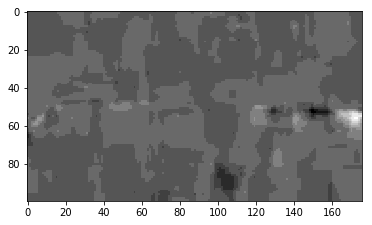

img y shape: (100, 176)


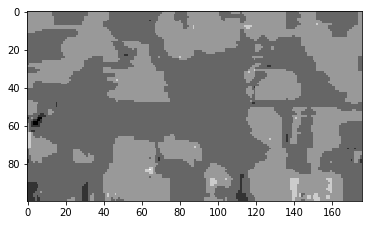

img stack shape: (100, 176, 2) 

opt x: //home/jovyan/at073-group50/dataset/20bn_jester_opt_x/train/Doing other things/102282/00003.jpg 
opt y: //home/jovyan/at073-group50/dataset/20bn_jester_opt_y/train/Doing other things/102282/00003.jpg
img x shape: (100, 176)


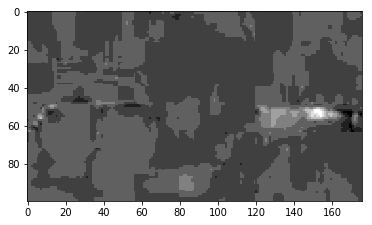

img y shape: (100, 176)


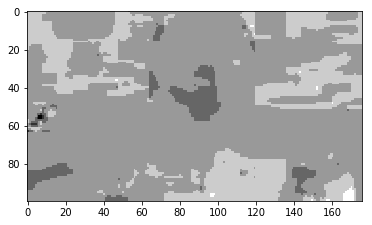

img stack shape: (100, 176, 2) 

opt x: //home/jovyan/at073-group50/dataset/20bn_jester_opt_x/validation/Doing other things/100090/00001.jpg 
opt y: //home/jovyan/at073-group50/dataset/20bn_jester_opt_y/validation/Doing other things/100090/00001.jpg
img x shape: (100, 176)


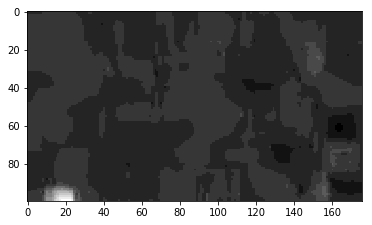

img y shape: (100, 176)


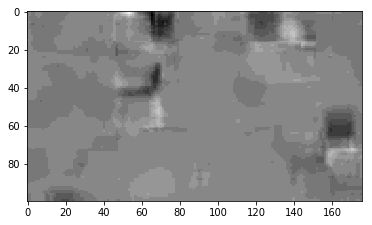

img stack shape: (100, 176, 2) 

opt x: //home/jovyan/at073-group50/dataset/20bn_jester_opt_x/validation/Doing other things/100090/00002.jpg 
opt y: //home/jovyan/at073-group50/dataset/20bn_jester_opt_y/validation/Doing other things/100090/00002.jpg
img x shape: (100, 176)


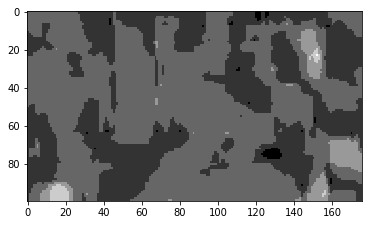

img y shape: (100, 176)


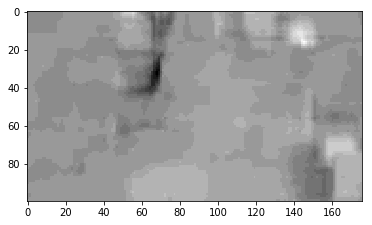

img stack shape: (100, 176, 2) 

opt x: //home/jovyan/at073-group50/dataset/20bn_jester_opt_x/validation/Doing other things/100090/00003.jpg 
opt y: //home/jovyan/at073-group50/dataset/20bn_jester_opt_y/validation/Doing other things/100090/00003.jpg
img x shape: (100, 176)


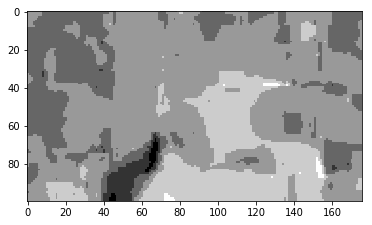

img y shape: (100, 176)


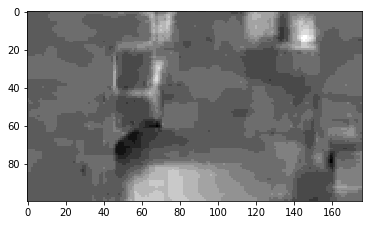

img stack shape: (100, 176, 2) 



In [1]:
%run PreProcess_FLOW.ipynb

In [2]:
import datetime
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers import Input, Dense, Flatten
from keras.layers import average, Dropout, Reshape, Lambda, Conv3D, Activation
from keras.layers.convolutional import AveragePooling3D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.applications.inception_v3 import preprocess_input
from keras.utils import multi_gpu_model
from i3d_inception import Inception_Inflated3d, conv3d_bn

Using TensorFlow backend.


In [3]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
weight_dir = 'pretained_weight/'
model_name = 'FLOW_Inception_i3d.h5'
log_file = 'FLOW_Inception_i3d.csv'
result_file = 'FLOW_Inception_i3d.csv'
weight_file = 'flow_inception_i3d_imagenet_and_kinetics_tf_dim_ordering_tf_kernels_no_top.h5'
runlog_folder = 'Log/'
runlog_file = "LogFLOW_Inception_i3d.txt"

# Use ModelCheckpoint to save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)

#Check Folder
if not os.path.isdir(runlog_folder):
    os.mkdir(runlog_folder) #Create Folder
#Delete Old Log
if os.path.isfile(runlog_folder + runlog_file):
    os.remove(runlog_folder + runlog_file)

#Define Write Log Func
def writeLog(msg):
    print(msg)
    with open(runlog_folder + runlog_file, "a") as myfile:
        myfile.write(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + ' ')
        myfile.write(msg)
        myfile.write("\n")

In [4]:
#取得GPU_NUM
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
gpu_num = len(get_available_gpus())

In [5]:
# Convert class vectors to categorical class matrices.
trainSet_y = keras.utils.to_categorical(trainSet['class'].values, num_classes)
# The data, shuffled and split between train and test sets:
X_train, X_val, y_train, y_val = train_test_split(trainSet['subdir_path'].values, trainSet_y, test_size = 0.1)

print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)

print('y_train Shape:', y_train.shape)
print('y_val Shape:', y_val.shape)

X_train shape: (1170,)
X_val shape: (130,)
y_train Shape: (1170, 13)
y_val Shape: (130, 13)


In [6]:
img_x = 160
img_y = 100
img_channels = 2 #opt x and y
num_frames = 15

In [7]:
base_model = Inception_Inflated3d(include_top=False, weights=weight_dir + weight_file,
                input_shape=(num_frames, img_y, img_x, img_channels),
                classes=num_classes)
#接上自訂輸出
#x = base_model.output
#x = Dropout(0.3)(x)
#x = conv3d_bn(x, num_classes, 1, 1, 1, padding='same', 
#        use_bias=True, use_activation_fn=False, use_bn=False, name='Conv3d_6a_1x1')

#num_frames_remaining = int(x.shape[1])
#x = Reshape((num_frames_remaining, num_classes))(x)

# logits (raw scores for each class)
#x = Lambda(lambda x: K.mean(x, axis=1, keepdims=False),
#           output_shape=lambda s: (s[0], s[2]))(x)
#predictions = Activation('softmax', name='prediction')(x)

#去掉最後一層
base_model.layers.pop()
#接上自訂輸出
X = base_model.layers[-1].output
X = AveragePooling3D((2,2,2))(X)
X = Flatten()(X)
predictions = Dense(num_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=predictions)   
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 100, 160, 0                                            
__________________________________________________________________________________________________
Conv3d_1a_7x7_conv (Conv3D)     (None, 8, 50, 80, 64 43904       input_1[0][0]                    
__________________________________________________________________________________________________
Conv3d_1a_7x7_bn (BatchNormaliz (None, 8, 50, 80, 64 192         Conv3d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv3d_1a_7x7 (Activation)      (None, 8, 50, 80, 64 0           Conv3d_1a_7x7_bn[0][0]           
__________________________________________________________________________________________________
MaxPool2d_

In [8]:
#多GPU模式
if gpu_num>=2:
    model = multi_gpu_model(model, gpus=gpu_num)

In [9]:
frameName = '/20bn_jester/'
optxName = '/20bn_jester_opt_x/'
optyName = '/20bn_jester_opt_y/'
def train_batch_generator(x, y, bs, nf):
    x_train = []
    y_train = []
    while True:
        new_ind = shuffle(range(len(x)))
        x = np.take(x, new_ind, axis=0)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            #從SDIR取得FRAME
            files = sorted(os.listdir(x[i]))            
            for f in files:                
                if (f.find('.jpg') >=0):
                    frames = []
                    sNum = int(f.replace('.jpg',''))
                    if not os.path.isfile(x[i] + '{:0>5d}.jpg'.format(sNum+nf-1)):
                        continue
                    
                    for j in range(nf):
                        nextFile = x[i] + '{:0>5d}.jpg'.format(sNum+j)
                        filePathX = nextFile.replace(frameName, optxName)
                        filePathY = nextFile.replace(frameName, optyName)
                        imgX = cv2.imread(filePathX, 0)
                        imgY = cv2.imread(filePathY, 0)
                        imgX = cv2.resize(imgX, (img_x, img_y))
                        imgY = cv2.resize(imgY, (img_x, img_y))
                        frames.append(np.stack((imgX, imgY), axis=-1))                           
                        
                    x_train.append(preprocess_input(np.array(frames)))
                    #x_train.append(frames)
                    y_train.append(y[i])
                    if len(x_train) == bs:
                        x_batch = np.array(x_train).copy()
                        y_batch = np.array(y_train).copy()
                
                        x_train = []
                        y_train = []
                        yield x_batch, y_batch
                
def val_batch_generator(x, y, bs, nf):
    x_val = []
    y_val = []
    while True:
        #new_ind = shuffle(range(len(x)))
        #x = np.take(x, new_ind, axis=0)
        #y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            #從SDIR取得FRAME
            files = sorted(os.listdir(x[i]))            
            for f in files:                
                if (f.find('.jpg') >=0):
                    frames = []
                    sNum = int(f.replace('.jpg',''))
                    if not os.path.isfile(x[i] + '{:0>5d}.jpg'.format(sNum+nf-1)):
                        continue
                    
                    for j in range(nf):
                        nextFile = x[i] + '{:0>5d}.jpg'.format(sNum+j)
                        img = cv2.imread(nextFile)
                        filePathX = nextFile.replace(frameName, optxName)
                        filePathY = nextFile.replace(frameName, optyName)
                        imgX = cv2.imread(filePathX, 0)
                        imgY = cv2.imread(filePathY, 0)
                        imgX = cv2.resize(imgX, (img_x, img_y))
                        imgY = cv2.resize(imgY, (img_x, img_y))
                        frames.append(np.stack((imgX, imgY), axis=-1))                         
                        
                    x_val.append(preprocess_input(np.array(frames)))
                    #x_val.append(frames)
                    y_val.append(y[i])
                    if len(x_val) == bs:
                        x_batch = np.array(x_val).copy()
                        y_batch = np.array(y_val).copy()
                
                        x_val = []
                        y_val = []
                        yield x_batch, y_batch                          
                
def test_batch_generator(x, bs, nf):
    x_test = []
    while True:
        for i in range(len(x)):
            #從SDIR取得FRAME
            files = sorted(os.listdir(x[i]))            
            for f in files:                
                if (f.find('.jpg') >=0):
                    frames = []
                    sNum = int(f.replace('.jpg',''))
                    if not os.path.isfile(x[i] + '{:0>5d}.jpg'.format(sNum+nf-1)):
                        continue
                    
                    for j in range(nf):
                        nextFile = x[i] + '{:0>5d}.jpg'.format(sNum+j)
                        filePathX = nextFile.replace(frameName, optxName)
                        filePathY = nextFile.replace(frameName, optyName)
                        imgX = cv2.imread(filePathX, 0)
                        imgY = cv2.imread(filePathY, 0)
                        imgX = cv2.resize(imgX, (img_x, img_y))
                        imgY = cv2.resize(imgY, (img_x, img_y))
                        frames.append(np.stack((imgX, imgY), axis=-1))                         
                        
                    x_test.append(preprocess_input(np.array(frames)))
                    #x_test.append(frames)
                    if len(x_test) == bs:
                        x_batch = np.array(x_test).copy()
                
                        x_test = []
                        yield x_batch

In [10]:
# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              #optimizer=Adam(lr=0.0001),
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=1, min_lr=0.1e-8)
csv_logger = CSVLogger('Log/' + log_file)

In [11]:
batch_size = 64 * gpu_num
epochs = 30

In [12]:
train_nums = CountFrameNums(X_train, num_frames)
val_nums = CountFrameNums(X_val, num_frames)
test_nums = CountFrameNums(testSet['subdir_path'], num_frames)
print('train frames:', train_nums)
print('val frames:', val_nums)
print('test frames:', test_nums)

train frames: 25167
val frames: 2809
test frames: 2888


In [ ]:
train_gen = train_batch_generator(X_train, y_train, batch_size, num_frames)
val_gen = val_batch_generator(X_val, y_val, batch_size, num_frames)

writeLog('Starting Training.')
model_history = model.fit_generator(
                        generator=train_gen, steps_per_epoch=math.ceil(train_nums / batch_size),
                        epochs=epochs, workers=4, shuffle=True,
                        validation_data=val_gen, validation_steps=math.ceil(val_nums / batch_size),
                        callbacks=[checkpoint, early_stopper, 
                                   lr_reducer, csv_logger])

Starting Training.
Epoch 1/30
197/197 [==============================] - 1005s 5s/step - loss: 1.8964 - acc: 0.3700 - val_loss: 1.4814 - val_acc: 0.5124

Epoch 00001: val_loss improved from inf to 1.48136, saving model to /home/jovyan/Hand/i3d/saved_models/FLOW_Inception_i3d.h5
Epoch 2/30
197/197 [==============================] - 993s 5s/step - loss: 1.0759 - acc: 0.6369 - val_loss: 0.9607 - val_acc: 0.7045

Epoch 00002: val_loss improved from 1.48136 to 0.96075, saving model to /home/jovyan/Hand/i3d/saved_models/FLOW_Inception_i3d.h5
Epoch 3/30
135/197 [===================>..........] - ETA: 4:27 - loss: 0.6254 - acc: 0.7849

In [ ]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_auc")
plt.plot(val_acc, label="validation_auc")
plt.xlabel("Epochs")
plt.ylabel("Auc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [ ]:
# loading our save model
writeLog('Loading trained model.')
model = load_model(model_path)

#多GPU模式
if gpu_num>=2:
    model = multi_gpu_model(model, gpus=gpu_num)

In [ ]:
# Let's train the model using Adam
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
# Score trained model.
val_gen = val_batch_generator(X_val, y_val, batch_size, num_frames)

scores = model.evaluate_generator(generator=val_gen, steps=math.ceil(val_nums / batch_size), verbose=1)
writeLog('Val loss: {}'.format(scores[0]))
writeLog('Val accuracy: {}'.format(scores[1]))

In [ ]:
# Score trained model.
testSet_y = keras.utils.to_categorical(testSet['class'].values, num_classes)
val_gen = val_batch_generator(testSet['subdir_path'], testSet_y, batch_size, num_frames)

scores = model.evaluate_generator(generator=val_gen, steps=math.ceil(test_nums / batch_size), verbose=1)
writeLog('Test loss: {}'.format(scores[0]))
writeLog('Test accuracy: {}'.format(scores[1]))